# <b>Lab 2</b>: Classifications: Logistics, SVM, KNN, and RandomForest
# <center><font color='blue'>Student Exam Scores Extended Dataset</font></center> 
***
### <center><b> Team Members: </b> Joey Hernandez, Daniel Chang, and Vo Nguyen</center>

### <b>Table of Contents</b>
<a class="anchor" id="toc"></a>
* **[Data Preprocessing](#data)**
    * [Import Packages](#import)
    * [Loading the Data](#load)
    * [One-Hot Encoding](#hot)
* **[Exceptional Work](#work)**
* **[Conclusion](#conclusion)**

### Import Packages [↑](#toc)
<a class="anchor" id="import"></a>

In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
sns.set_style('whitegrid')


### Loading the Data [↑](#toc)
<a class="anchor" id="load"></a>

In [ ]:
df = pd.read_csv('cleandf.csv')
display(df)

### One-Hot Encode [↑](#toc)
<a class="anchor" id="hot"></a>

One Hot-Encode

In [ ]:
df_dummy = pd.get_dummies(df, columns=['Gender', 'LunchType', 'TestPrep', 'IsFirstChild','TransportMeans'],
                          drop_first=True)
df_dummy["WklyStudyHours"] = [1 if x == '> 10' else 0 for x in df_dummy["WklyStudyHours"]]

df_dummy["PracticeSport"] = [0 if x == 'never' else 1 for x in df_dummy["PracticeSport"]]

math_df = df_dummy.drop(["ReadingResult", "WritingResult", "MathScore"], axis = 1)

math_df['HasSiblings'] = math_df['NrSiblings'].apply(lambda x: 1 if x > 0 else 0)

math_df.drop('NrSiblings', axis=1, inplace=True)

## Creating train test split and assigning Variables to Expl | Response

In [ ]:
math_df['MathResultNum'] = np.where(math_df['MathResult'] == "Pass", 1, 0)



# Logistic Regression or SVM - VO

### Import Packages for Logistics Regression

In [92]:
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
sns.set_style('whitegrid')
from pandas import Series,DataFrame
import numpy as np
import statsmodels.formula.api as smf


### Plot of our Target Variable
The plots have a slight imbalance dataset

In [ ]:
sns.countplot(data = math_df, x = 'MathResultNum')
plt.show()

Since we have an imbalance dataset. We can use the Receiver Operating Characteristic(ROC) curve to the examin the area under curve (AUC). The threshold that maximmizes our trade-off between true positive(sensitivity) and false posited rate can be a considered a good theshold for our classification. 

### Logistic Regression Model Summary

In [ ]:
# building the model and fitting the data
Target = math_df["MathResultNum"]
feature_columns = math_df.drop(["EthnicGroup", "ParentEduc", "ParentMaritalStatus", "MathResult", "HasSiblings","MathResultNum"], axis = 1)
formula = "MathResultNum ~ " + " + ".join(feature_columns)

log_reg = smf.logit(formula, data=math_df).fit()

print(log_reg.summary())

## External Cross Validation using SKLEARN

### Training a Logistic Regression Model 70-30 split

In [100]:
Train, Test= train_test_split(math_df, train_size = .7, test_size= .3, random_state=5)

X_train = Train.drop(["EthnicGroup", "ParentEduc", "ParentMaritalStatus", "MathResult", "HasSiblings","MathResultNum"], axis = 1)
y_train = Train.MathResultNum

X_test = Test.drop(["EthnicGroup", "ParentEduc", "ParentMaritalStatus", "MathResult", "HasSiblings","MathResultNum"], axis = 1)
y_test = Test.MathResultNum

#Create Logistic Classifier and Fit
clf = LogisticRegression(random_state=0).fit(X_train,y_train)

#Create Prediction Set
preds = clf.predict(X_test)

#Accuracy Method 1
print("Accuracy:",metrics.accuracy_score(y_test, preds))

#RMSE
MSE = mean_squared_error(y_test,preds)
rmse = np.sqrt(MSE)
print("RMSE:", rmse)

Accuracy: 0.8829544218427064
RMSE: 0.3421192455230977


### Stratified 10-Fold Cross Validation for Training the Logistic Regression Model

In [102]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

X = math_df[['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none']]
y = math_df['MathResultNum']

log_clf = LogisticRegression(random_state=0)

cross_val_scores = cross_val_score(log_clf, X, y, cv=10)

avg_accuracy = cross_val_scores.mean()

print("Average CV Score Accuracy:", avg_accuracy)

preds = cross_val_predict(log_clf, X, y, cv=10)

MSE = mean_squared_error(y,preds)
rmse = np.sqrt(MSE)
print("RMSE:", rmse)


Average CV Score Accuracy: 0.8786920572112497
RMSE: 0.3482930537691049


Both are roughly the same

### Plot the AUC

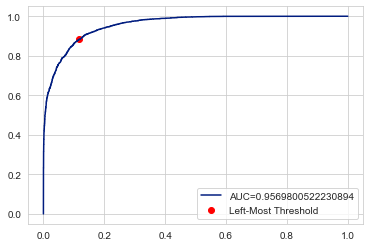

In [79]:
#Import Packages
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = clf.predict_proba(X_test)[:,1]
fpr,tpr, thresholds = roc_curve(y_test,y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)

#Find the Left Most Index
leftmost_index = np.nanargmin(np.abs(fpr - (1 - tpr)))
leftmost_fpr = fpr[leftmost_index]
leftmost_tpr = tpr[leftmost_index]

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.scatter(leftmost_fpr, leftmost_tpr, color='red', label="Left-Most Threshold")
plt.legend(loc=4)
plt.show()


### Confusion Matrix for Logistic

Text(0.5, 16.0, 'Predicted Outcome')

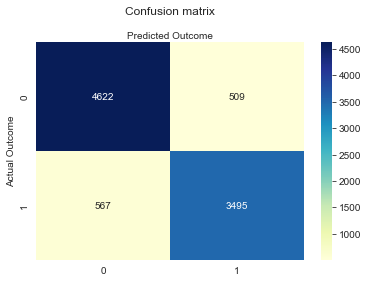

In [81]:
cnf_matrix = metrics.confusion_matrix(y_test, preds)

labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual Outcome')
plt.xlabel('Predicted Outcome')

In [83]:
Performance = DataFrame({"Actual":y_test,"Predicted":preds})
Performance["Subtract"] = Performance["Actual"]-Performance["Predicted"]
Accuracy = (Performance["Actual"].count() - sum(abs(Performance["Subtract"])))/Performance["Actual"].count()
print("Accuracy Method 2")
print(Accuracy)

from sklearn.metrics import classification_report
print(classification_report(y_test, preds))
print("No Informaiton Rate")
print(np.mean(1-math_df["MathResultNum"]))

Accuracy Method 2
0.8829544218427064
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      5131
           1       0.87      0.86      0.87      4062

    accuracy                           0.88      9193
   macro avg       0.88      0.88      0.88      9193
weighted avg       0.88      0.88      0.88      9193

No Informaiton Rate
0.5632975425084038


# KNN - Joey

## Import Packages for KNN, TTS, ETC

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

## View Occurances of MathResultNum

In [ ]:
sns.countplot(data = math_df, x = 'MathResult')
plt.show()

### There seems to be evidence of a slight imbalance in our repsonse variable. Because of this we will proceed with Stratified Cross Validation for splitting up our data.

In [80]:
counts = math_df['MathResult'].value_counts()
ratio = counts[0] / counts[1]
print('Class Imbalance Ratio:', ratio)

Class Imbalance Ratio: 1.2898886480831029


## Normalize The continous Variables for use in KNN

Becuase our model will contain both binary variable and continuous variables we will normlize the two continuous variables to ensure that KNN is making accurate predictions. 

KNN is a distance based algorithm, meaning it will rely on measuring distance between data points to make predictions. When features have different scales, attributes with larger values may dominate the distance calcuations.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_math_df = math_df
scale_math_df[['ReadingScore','WritingScore']] = scaler.fit_transform(math_df[['ReadingScore','WritingScore']])

### Setting Variables for X, Y

In [ ]:
X = scale_math_df[['Gender_male',"LunchType_standard",'WritingScore', 'ReadingScore','TestPrep_none']]
y = scale_math_df['MathResultNum']

### Initialize the KNN Classifier

In [ ]:
knn = KNeighborsClassifier()

### Specifiy Params and perform Grid Search

In [ ]:
param_grid = {'n_neighbors':[2,3,5,7,9,11,13,15,19]}

grid_search = GridSearchCV(knn, param_grid, cv = 5)
grid_search.fit(X, y)

### View Grid Search Results

Although the "best" accuracy is achieved with 19 Neighbors, we will proceed with using 9 neighbors. There is little improvement in accuracy after 9 neighbors and the added complexity to the model does not seem "worth" the small additon of accuracy.

In [ ]:
grid_search_results = grid_search.cv_results_
print('Grid Search Results')
for mean_score, params in zip(grid_search_results['mean_test_score'], grid_search_results['params']):
    print(f'Parameters: {params} | Mean Accuracy: {mean_score}')

## View Best Results

In [ ]:
best_knn = grid_search.best_estimator_
print(best_knn)

## Running KNN with Desired k = 9 & Stratified 10 Fold Cross Validation

- Revisting the count plot for "Pass/Fail" instances above, we find that there is evidence which suggests a slight imbalance in our data exists. Because of this imbalance in our data we will proceed with a Stratified 10 Fold Cross Validation method for splitting our data. 

- Compared to the 'train_test_split' the Stratified Cross validation method allows us a bit more precision when working with an unbalanced response variable. 

In [90]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors = 9)

cross_val_scores = cross_val_score(knn, X, y, cv=10)

NameError: name 'KNeighborsClassifier' is not defined

In [ ]:
print('Cross-Validation Score:',cross_val_scores)

In [ ]:
avg_accuracy = cross_val_scores.mean()

print('Average Accuracy', avg_accuracy)

In [ ]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(knn, X, y, cv=10)

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)
print('RMSE', rmse)

# Model Evaluation

When evaluating KNN we will use the following metrics:

- **Confusion Matrix:** Provides tabular representation of the predicted versus acutal class labels. The confusion matrix 
allows for a detailed analysis of the model's performance and evaluation of different metrics (some of which we will include below)<br><br>

- **Accuracy:** Will help us to assess the overall Correctness of the model predictions. While it is not particualrly useful as a standalone metric it will provide a piece to a comprehensive look at our model performance.<br><br>

- **Precision:** It represents the proportion of correctly predicted positive instances (true positives) out of the total instances predicted as positive. Precision is useful when the cost of false positives is high, and we want to minimize false positives. It's important that we are able to identify students whom are classified as a "True Pass" so that we can ensure students are receiving the needed attention and help.<br><br>

- **Recall** Provides a measure for how many actual positive instances are correctly predicted as positive. "of all the positive instances how many are correctly predicted" This is important for us to understand so that we are not classiying students as "Pass" when they are actually likely to fail, which may prevent them from receiving the help they need.<br><br>

- **F1 Score:** By considering precision and recall simultaneously, the F1 score provides a balanced and comprehensive assessment of the model's performance for grade pass/fail classification. It helps in evaluating the model's ability to correctly identify both pass and fail cases, addressing imbalanced performance, and incorporating the potential costs associated with misclassifications in a meaningful way.<br><br>

- **AUC:** Represents the overall performance of the classifier across various classification thresholds. AUC-ROC is particularly useful when evaluating binary classification problems with imbalanced classes or when the emphasis is on ranking the instances.<br><br>

In [ ]:
confusion_mat = confusion_matrix(y, y_pred)
print('Confusion Matrix', confusion_mat)

In [ ]:
sns.heatmap(confusion_mat, annot=True, fmt = 'd', cmap = 'mako')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KNN Confusion Matrix')
plt.show()

In [ ]:
TP = 11439 
FP = 2042
FN = 1942
TN = 15218

accuracy = (TP + TN)/ (TP + TN + FP + FN)
sensitivity = TP / (TP+FN)
specificity = TN / (TN+FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall)/ (precision + recall)

print('Accuracy', accuracy *100 ,'\n')
print('Sensitivity', sensitivity*100,'\n')
print('Specificity', specificity*100,'\n')
print('Precision', precision*100,'\n')
print('Recall', recall*100,'\n')
print('F1 - Score', f1_score*100,'\n')
print('RMSE', rmse)

## ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc
y_scores = cross_val_predict(knn, X, y, cv= 10, method = 'predict_proba')[:,1]


# false/true postive & threshold
fpr, tpr, thresholds = roc_curve(y, y_scores)

#roc calc
roc_auc = auc(fpr, tpr)


In [ ]:
plt.plot(fpr, tpr, label = 'ROC Curve(AUC = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc= 'lower right')


plt.show()

The ROC Curve is represented by the line connecting the points defined by the False Positive Rate (FPR) on the x-axis and the True Positive Rate (TPR) on the y-axis. Each point on the curve corresponds to a different classification threshold. The curve visually illustrates the trade-off between the true positive rate and the false positive rate at different thresholds.

The AUC (Area under the curve) ranges from 0 to 1, where a higher value signifies better discriminative power and overall performance of the model. In this case our AUC is .94. 


### Analyzing Results

- **Accuracy:** 87

- **Precision:** 85

- **Recall:** 85

- **F1 Score:** 85.1

- **AUC-ROC:** 94

### Advantages to Using KNN

- **Simplicity:** KNN is a simple and intuitive algorithm that doesn't require complex assumptions or extensive parameter tuning. It is easy to understand and implement, making it accessible for users with limited machine learning experience. <br><br>
- **Flexibility:** KNN can handle both binary and continuous attributes, making it suitable for datasets with mixed data types. It can effectively incorporate different types of features into the classification process without requiring explicit feature engineering or transformation.
<br><br>
- **Non-linearity:** KNN is a non-parametric algorithm, meaning it doesn't make assumptions about the underlying data distribution. It can capture complex relationships and decision boundaries between features and the target variable, allowing for flexibility in modeling non-linear patterns.
<br><br>
- **Robustness to Outliers:** KNN is robust to outliers because it doesn't make strong assumptions about the data distribution. Outliers may have limited impact on the classification decision, as the majority vote is based on the nearest neighbors. This can be advantageous when dealing with datasets that contain noisy or inconsistent data.
<br><br>
- **Interpretability:** KNN provides interpretability as it can easily explain its predictions. The classification decision is based on the nearest neighbors, which can be visualized and understood by examining the neighboring instances and their corresponding class labels. This can be useful in scenarios where interpretability and explainability are important.
<br><br>
- **No Training Phase:** KNN is a lazy learning algorithm, meaning it does not have an explicit training phase. The model stores the entire training dataset and makes predictions at runtime based on the nearest neighbors. This allows for efficient adaptation to new data or incremental learning scenarios.

# Random Forest - Danny